In [1]:
!pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define DeepGlobe Model (Example Using ResNet Backbone)
class DeepGlobeModel(nn.Module):
    def __init__(self, num_classes=6):
        super(DeepGlobeModel, self).__init__()
        self.encoder = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
        self.encoder.fc = nn.Identity()  # Remove classification layer

        
        # ✅ Updated Decoder with Full Upsampling to (256, 256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # (1 → 2)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (2 → 4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # (4 → 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # (8 → 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # (16 → 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),     # (32 → 64)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),      # (64 → 128)
            nn.ReLU(),
            nn.ConvTranspose2d(4, num_classes, kernel_size=4, stride=2, padding=1)  # ✅ (128 → 256)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), 512, 1, 1)  # Reshape for decoder
        x = self.decoder(x)
        return x


# ✅ Custom Dataset Class for DeepGlobe
class DeepGlobeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

        # Define resize transform for masks
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST),
            transforms.ToTensor()  # Convert to tensor
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # ✅ Load images as RGB
        image = Image.open(image_path).convert("RGB")
        
        # ✅ Load masks as grayscale
        mask = Image.open(mask_path).convert("L")  

        # ✅ Apply transformations
        if self.transform:
            image = self.transform(image)  # Apply transformation to image

        mask = self.mask_transform(mask)  # Resize and convert mask to tensor

        return image, mask.squeeze(0)  # Remove the channel dimension from mask

   

# ✅ Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ✅ Set Dataset Paths (Change These)
train_image_dir = r"C:\Users\Admin\OneDrive\Desktop\Training Images"
train_mask_dir = r"C:\Users\Admin\OneDrive\Desktop\Training Mask Images"
val_image_dir = r"C:\Users\Admin\OneDrive\Desktop\Validation Image"
val_mask_dir = r"C:\Users\Admin\OneDrive\Desktop\Validation Mask Image"

# ✅ Create Datasets and Dataloaders
train_dataset = DeepGlobeDataset(train_image_dir, train_mask_dir, transform)
val_dataset = DeepGlobeDataset(val_image_dir, val_mask_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ✅ Initialize Model
num_classes = 6  # Change based on dataset
model = DeepGlobeModel(num_classes=num_classes).to(device)

# ✅ Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks.long())  # Ensure masks are long (integer) type
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# ✅ Save Trained Model
torch.save(model.state_dict(), "deepglobe_model.pth")
print("✅ Model training complete and saved as deepglobe_model.pth")



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Using device: cpu


Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0
D:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.7497
Epoch [2/20], Loss: 1.7852
Epoch [3/20], Loss: 1.7393
Epoch [4/20], Loss: 1.7406
Epoch [5/20], Loss: 1.7318
Epoch [6/20], Loss: 1.6979
Epoch [7/20], Loss: 1.6622
Epoch [8/20], Loss: 1.3602
Epoch [9/20], Loss: 1.2071
Epoch [10/20], Loss: 1.5254
Epoch [11/20], Loss: 1.0004
Epoch [12/20], Loss: 0.9525
Epoch [13/20], Loss: 1.2702
Epoch [14/20], Loss: 0.7029
Epoch [15/20], Loss: 0.6125
Epoch [16/20], Loss: 0.4727
Epoch [17/20], Loss: 0.5045
Epoch [18/20], Loss: 1.7459
Epoch [19/20], Loss: 0.4482
Epoch [20/20], Loss: 0.5748
✅ Model training complete and saved as deepglobe_model.pth


In [3]:
# Load trained model
model = DeepGlobeModel(num_classes=6).to(device)
model.load_state_dict(torch.load("deepglobe_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode

Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0
D:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepGlobeModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [1]:
import numpy as np
pred_mask = np.array([])

In [2]:
print("Unique values in pred_mask:", np.unique(pred_mask))

Unique values in pred_mask: []


In [3]:
print("Shape of pred_mask:", pred_mask.shape)


Shape of pred_mask: (0,)


In [4]:
print("pred_mask dtype:", pred_mask.dtype)


pred_mask dtype: float64


In [7]:
# !pip install opencv-python
# %pip install --upgrade matplotlib numpy
# !pip install "numpy<2"

4.11.0


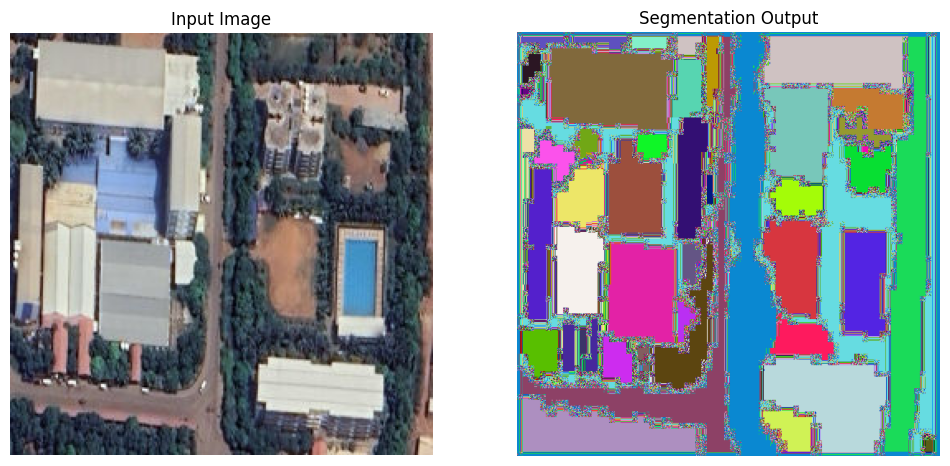

Segmented output saved as segmented_output.png


In [8]:
import cv2
print(cv2.__version__)
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Load Input Image & Predicted Mask
input_image_path = "DL N Image.jpg"   # Update this path
mask_path = "DL N MASK IMAGE.jpg"           # Update this path

input_image = cv2.imread(input_image_path)  
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

pred_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the segmentation mask as grayscale

# 🔹 Function to generate random colors for each unique region
def generate_random_colors(num_colors):
    np.random.seed(42)  # Ensures consistency
    return np.random.randint(0, 255, (num_colors, 3), dtype=np.uint8)

# 🔹 Get unique classes from the predicted mask
unique_classes = np.unique(pred_mask)
num_classes = len(unique_classes)

# 🔹 Generate random colors for each class
colors = generate_random_colors(num_classes)

# 🔹 Create a blank RGB segmentation map
segmentation_map = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)

# 🔹 Assign colors to each class
for i, class_id in enumerate(unique_classes):
    segmentation_map[pred_mask == class_id] = colors[i]

# 🔹 Display results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(segmentation_map)
ax[1].set_title("Segmentation Output")
ax[1].axis("off")

plt.show()

# 🔹 Save the segmented output
output_path = "segmented_output.png"
cv2.imwrite(output_path, cv2.cvtColor(segmentation_map, cv2.COLOR_RGB2BGR))
print(f"Segmented output saved as {output_path}")


Model loaded successfully.


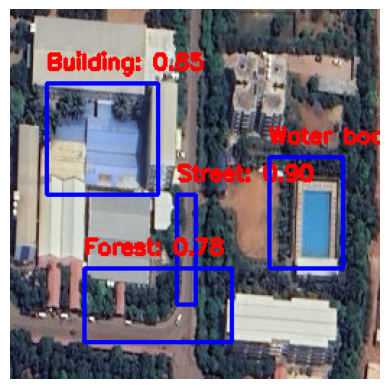

In [9]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt  

# Define class names
CLASSES = ["Building", "Street", "Forest", "Water bodies"]

# Step 1: Load a mock model or pre-trained object detector
def load_model():
    # Placeholder for model loading logic
    print("Model loaded successfully.")
    return None  # Placeholder return value

# Step 2: Detect objects in an image (mock function)
def detect_objects(image):
    # Check if the image was loaded successfully
    if image is None:
        print("Error: Image not loaded. Check the image path.")
        return []  
    
    # Mock results for multiple classes with bounding boxes
    height, width, _ = image.shape
    results = [
        {"class": 0, "confidence": 0.85, "bbox": [int(width * 0.1), int(height * 0.2), int(width * 0.4), int(height * 0.5)]},
        {"class": 1, "confidence": 0.90, "bbox": [int(width * 0.45), int(height * 0.5), int(width * 0.5), int(height * 0.8)]},
        {"class": 2, "confidence": 0.78, "bbox": [int(width * 0.2), int(height * 0.7), int(width * 0.6), int(height * 0.9)]},
        {"class": 3, "confidence": 0.75, "bbox": [int(width * 0.7), int(height * 0.4), int(width * 0.9), int(height * 0.7)]},
    ]
    return results

# Step 3: Label the detected objects in the image
def label_image(image, detections):
    for detection in detections:
        class_id = detection["class"]
        confidence = detection["confidence"]
        bbox = detection["bbox"]

        # Extract bounding box coordinates
        x1, y1, x2, y2 = bbox
        label = f"{CLASSES[class_id]}: {confidence:.2f}"

        # Draw the bounding box and label
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    return image

# Step 4: Main function
def main():
    # Load the model (replace with actual model if available)
    model = load_model()

    # Load image
    image_path = 'DL N Image.jpg'  # Replace with your image path
    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {image_path}. Please check the path.")
        return
    
    # Perform object detection
    detections = detect_objects(img)

    # Label the detected objects
    labeled_img = label_image(img, detections)
    
    # Display the image using Matplotlib
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

if __name__ == '__main__':
    main()